<a href="https://colab.research.google.com/github/egyvedriyanto78/Deep-Learning/blob/main/Butterfly_LeNet_5_by_EgyVedriyanto_2117051035.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Eksperimen Model LeNet-5 untuk klasifikasi Kupu-kupu yang terdiri dari 8 kelas
Egy Vedriyanto 2117051035

## Library

In [1]:
# Mengimpor library yang diperlukan
# Ini termasuk library PyTorch, matplotlib untuk visualisasi, dan utilitas lainnya
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Mengecek apakah GPU tersedia untuk pelatihan
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


## Dataset

In [2]:
# Mengimpor Google Drive untuk mengakses dataset
from google.colab import drive
drive.mount('/content/drive')

# Path ke dataset kupu-kupu di Google Drive
dataset_path = '/content/drive/My Drive/Computer Vision/butterfly_dataset'

Mounted at /content/drive


In [22]:
# Transformasi dengan augmentasi untuk train dataset
# Melibatkan flipping, rotasi, dan penyesuaian brightness/contrast
transform_train = transforms.Compose([
    transforms.Resize((32, 32)),  # Tentukan ukuran gambar
    transforms.RandomHorizontalFlip(),       # Flipping horizontal secara acak
    transforms.RandomRotation(30),          # Rotasi hingga 30 derajat
    transforms.ColorJitter(brightness=0.2, contrast=0.2),  # Penyesuaian brightness & contrast
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))    # Normalisasi ke rentang [-1, 1]
])

# Transformasi tanpa augmentasi untuk validation dan test dataset
transform_no_augment = transforms.Compose([
    transforms.Resize((32, 32)),  # Tentukan ukuran gambar
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))    # Normalisasi ke rentang [-1, 1]
])

# Load dataset menggunakan ImageFolder
# Transformasi hanya diterapkan pada data sesuai kebutuhan
dataset = datasets.ImageFolder(root=dataset_path)

# Membagi dataset menjadi train, validation, dan test
train_size = int(0.7 * len(dataset))  # 70% untuk training
val_size = int(0.2 * len(dataset))    # 20% untuk validasi
test_size = len(dataset) - train_size - val_size  # Sisa untuk testing
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Terapkan transformasi sesuai subset
train_dataset.dataset = datasets.ImageFolder(root=dataset_path, transform=transform_train)
val_dataset.dataset = datasets.ImageFolder(root=dataset_path, transform=transform_no_augment)
test_dataset.dataset = datasets.ImageFolder(root=dataset_path, transform=transform_no_augment)

# Membuat DataLoader untuk batch training
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)  # Shuffle untuk train
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)    # Tidak perlu shuffle
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)  # Tidak perlu shuffle

print(f"Dataset berhasil dimuat. Train: {train_size}, Val: {val_size}, Test: {test_size}")

Dataset berhasil dimuat. Train: 556, Val: 159, Test: 80


## Modeling

In [24]:
# Definisi arsitektur LeNet-5
class LeNet5(nn.Module):
    def __init__(self, num_classes):
        super(LeNet5, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, kernel_size=5)  # Input RGB (3 channels)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_classes)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.max_pool2d(x, 2, 2)
        x = torch.relu(self.conv2(x))
        x = torch.max_pool2d(x, 2, 2)
        x = x.view(-1, 16 * 5 * 5)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Inisialisasi model
num_classes = len(dataset.classes)
model = LeNet5(num_classes).to(device)
print(model)

LeNet5(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=8, bias=True)
)


In [25]:
# Menggunakan CrossEntropyLoss untuk klasifikasi multi-kelas
criterion = nn.CrossEntropyLoss()

# Optimizer menggunakan SGD
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

## Model Training

In [26]:
# Fungsi untuk melatih model
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs):
    history = {'train_loss': [], 'val_loss': []}

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        avg_train_loss = running_loss / len(train_loader)
        history['train_loss'].append(avg_train_loss)

        # Validasi
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

        avg_val_loss = val_loss / len(val_loader)
        history['val_loss'].append(avg_val_loss)

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

    return history

# Melatih model
epochs = 20
history = train_model(model, train_loader, val_loader, criterion, optimizer, epochs)

Epoch 1/20, Train Loss: 2.0808, Val Loss: 2.0634
Epoch 2/20, Train Loss: 2.0476, Val Loss: 2.0211
Epoch 3/20, Train Loss: 1.9446, Val Loss: 1.9114
Epoch 4/20, Train Loss: 1.7620, Val Loss: 1.6257
Epoch 5/20, Train Loss: 1.4679, Val Loss: 1.4149
Epoch 6/20, Train Loss: 1.2816, Val Loss: 1.1438
Epoch 7/20, Train Loss: 1.0421, Val Loss: 0.9281
Epoch 8/20, Train Loss: 1.0205, Val Loss: 0.8715
Epoch 9/20, Train Loss: 0.7875, Val Loss: 0.7092
Epoch 10/20, Train Loss: 0.6993, Val Loss: 0.5926
Epoch 11/20, Train Loss: 0.5775, Val Loss: 0.5220
Epoch 12/20, Train Loss: 0.4157, Val Loss: 0.3431
Epoch 13/20, Train Loss: 0.3414, Val Loss: 0.1904
Epoch 14/20, Train Loss: 0.3957, Val Loss: 0.3924
Epoch 15/20, Train Loss: 0.4987, Val Loss: 0.3993
Epoch 16/20, Train Loss: 0.3762, Val Loss: 0.1599
Epoch 17/20, Train Loss: 0.3148, Val Loss: 0.2493
Epoch 18/20, Train Loss: 0.2388, Val Loss: 0.1970
Epoch 19/20, Train Loss: 0.2217, Val Loss: 0.1479
Epoch 20/20, Train Loss: 0.1667, Val Loss: 0.1897


## Model Evaluation

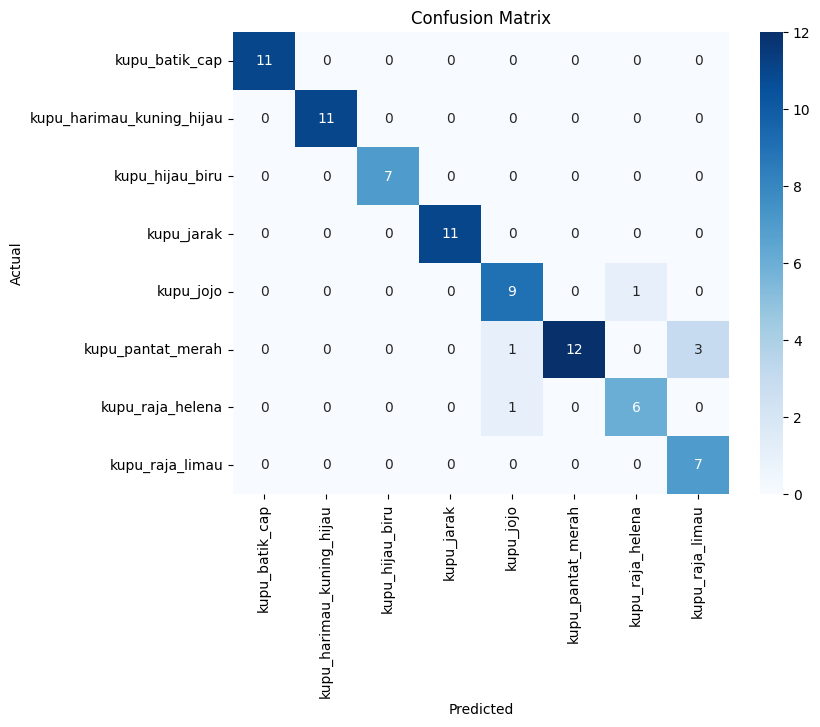

Classification Report:
                           precision    recall  f1-score   support

           kupu_batik_cap       1.00      1.00      1.00        11
kupu_harimau_kuning_hijau       1.00      1.00      1.00        11
          kupu_hijau_biru       1.00      1.00      1.00         7
               kupu_jarak       1.00      1.00      1.00        11
                kupu_jojo       0.82      0.90      0.86        10
        kupu_pantat_merah       1.00      0.75      0.86        16
         kupu_raja_helena       0.86      0.86      0.86         7
          kupu_raja_limau       0.70      1.00      0.82         7

                 accuracy                           0.93        80
                macro avg       0.92      0.94      0.92        80
             weighted avg       0.94      0.93      0.93        80



In [27]:
# Evaluasi model menggunakan test set
def evaluate_model(model, test_loader):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    return y_true, y_pred

y_true, y_pred = evaluate_model(model, test_loader)

# Confusion matrix dan classification report
cm = confusion_matrix(y_true, y_pred)
report = classification_report(y_true, y_pred, target_names=dataset.classes)

# Visualisasi confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=dataset.classes, yticklabels=dataset.classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

print("Classification Report:")
print(report)

## Model Prediction

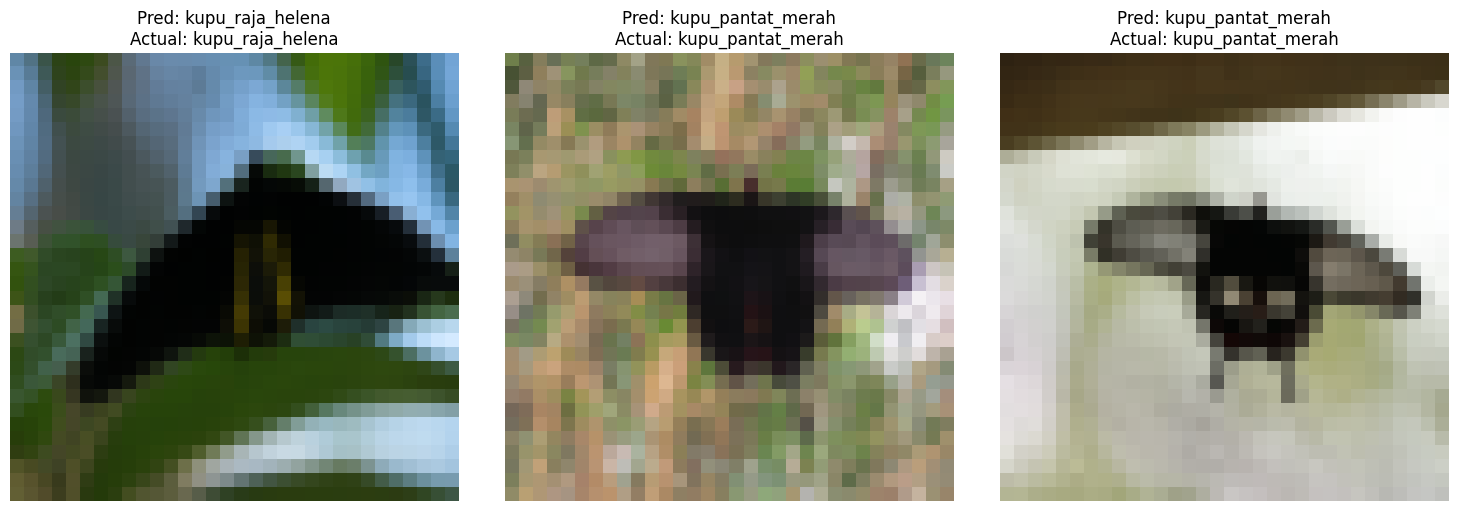

In [30]:
# Fungsi untuk menampilkan 3 gambar beserta prediksinya
def show_predictions(model, dataset, class_names, num_images=3):
    """
    Menampilkan beberapa gambar dari dataset, prediksi model, dan label aktualnya.
    Args:
        model: Model PyTorch yang sudah dilatih.
        dataset: Dataset yang akan digunakan untuk menampilkan gambar.
        class_names: Daftar nama kelas sesuai urutan indeks label.
        num_images: Jumlah gambar yang akan ditampilkan.
    """
    model.eval()  # Set model ke mode evaluasi
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))

    for i in range(num_images):
        idx = np.random.randint(len(dataset))  # Ambil indeks acak
        img, label = dataset[idx]  # Dapatkan gambar dan label
        img_tensor = img.unsqueeze(0).to(device)  # Tambahkan dimensi batch dan pindahkan ke GPU/CPU

        # Lakukan prediksi
        with torch.no_grad():
            output = model(img_tensor)  # Output model
            _, pred = torch.max(output, 1)  # Prediksi kelas

        # Denormalisasi gambar untuk ditampilkan
        img = img.permute(1, 2, 0).numpy() * 0.5 + 0.5  # Denormalisasi dari normalisasi [-1, 1] ke [0, 1]
        axes[i].imshow(img)
        axes[i].axis('off')
        axes[i].set_title(f"Pred: {class_names[pred.item()]}\nActual: {class_names[label]}")

    plt.tight_layout()
    plt.show()

# Contoh penggunaan
class_names = test_dataset.dataset.classes  # Ambil nama kelas dari dataset
show_predictions(model, test_dataset, class_names, num_images=3)